# Creating a simple cell optimisation

This notebook will explain how to set up an optimisation of simple Izhikevich cell with two free parameters that need to be optimised

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint as _print

First we need to import the module that contains all the functionality to create electrical cell models

In [2]:
import bluepyopt as bpop
import bluepyopt.ephys as ephys
import bluepyopt.ephys_pyNN as epyn
import deap.tools

If you want to see a lot of information about the internals, 
the verbose level can be set to 'debug' by commenting out
the following lines

In [3]:
# import logging
# logger = logging.getLogger()
# logger.setLevel(logging.DEBUG)

Setting up a cell template
-------------------------
First a template that will describe the cell population has to be defined. A template consists of:
* a PyNN cell type
* model parameters

We are going to use the PyNN `Izhikevich` cell type. We can see its parameters and their default values as follows:

In [4]:
from pyNN.standardmodels.cells import Izhikevich

Izhikevich.default_parameters

{'a': 0.02, 'b': 0.2, 'c': -65.0, 'd': 2.0, 'i_offset': 0.0}

### Creating parameters

A BluePyOpt parameter can be in two states: frozen and not-frozen. When a parameter is frozen it has an exact value, otherwise it only has some bounds but the exact value is not known yet.

We are going to freeze `c`, `d` and `i_offset`; only `a` and `b` will be optimised.

In [5]:
Parameter = bpop.parameters.ArrayParameter

parameters = [
    Parameter(name='a', bounds=[0.0, 1.0], frozen=False),
    Parameter(name='b', bounds=[0.0, 1.0], frozen=False),
    Parameter(name='c', value=-65.0, frozen=True),
    Parameter(name='d', value=6.0, frozen=True)
]

### Creating the template

To create the population template, we pass all these objects to the constructor of the template

In [6]:
POP_SIZE = 100
simple_population = epyn.models.PyNNPopulationModel(
        name='simple_population',
        size=POP_SIZE,
        celltype='Izhikevich',
        params=parameters,
        initial_values={'v': -70.0, 'w': 0.0})  

Now we can print out a description of the template

In [7]:
print(simple_population)

simple_population:
  cell type:
    Izhikevich
  params:
    a = [0.0, 1.0]
    b = [0.0, 1.0]
    c = -65.0
    d = 6.0



With this template we can build a population evaluator.

## Setting up a population evaluator

To optimise the parameters of the cells we need to create an evaluator object. 
This object will need to know which protocols to inject, which parameters to optimise, etc.

### Obtaining our target data

Since this is a demo, we are going to use the same model to produce the target data as we are fitting. We will then attempt to recover the correct parameters by fitting.

/home/andrew/anaconda/envs/simulation/lib/python3.5/site-packages/pyNN/nest/__init__.py:55: UserWarning: Unable to install NEST extensions. Certain models may not be available.
Further details: DynamicModuleManagementError in Install: Module 'pynn_extensions' could not be opened.
The dynamic loader returned the following error: 'file not found'.

Please check LD_LIBRARY_PATH (OSX: DYLD_LIBRARY_PATH)!
  warnings.warn("Unable to install NEST extensions. Certain models may not be available.\nFurther details: {}".format(err))


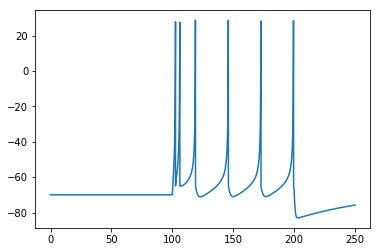

In [8]:
import pyNN.nest as sim

sim.setup(timestep=0.01)
cell_type = sim.Izhikevich(a=0.02, b=0.2, c=-65.0, d=6.0)
neuron = sim.Population(1, cell_type, initial_values={'v': -70.0, 'w': -14.0})
neuron.record('v')
step_parameters = {'start': 100.0, 'stop': 200.0, 'amplitude': 0.014}
injected_current = sim.DCSource(**step_parameters)
injected_current.inject_into(neuron)

sim.run(250.0)
data = neuron.get_data().segments[0]
vm = data.analogsignals[0]
plt.plot(vm.times, vm)


In [9]:
import efel
trace = {
    'T': vm.times.magnitude,
    'V': vm[:, 0].magnitude,
    'stim_start': [step_parameters['start']],
    'stim_end': [step_parameters['stop']]
}
trace_results = efel.getFeatureValues([trace],
                                      ['time_to_first_spike',
                                       'time_to_second_spike',
                                       'time_to_last_spike',
                                       'Spikecount'])
                   
feature_values = {}
for name, value in trace_results[0].items():
    feature_values[name] = value[0]
    print("Feature %s has the following values: %s" %
          (name, ', '.join([str(x) for x in value])))

Feature time_to_second_spike has the following values: 6.1
Feature time_to_first_spike has the following values: 2.6
Feature Spikecount has the following values: 6
Feature time_to_last_spike has the following values: 99.5


In [10]:
feature_values

{'Spikecount': 6,
 'time_to_first_spike': 2.5999999999984453,
 'time_to_last_spike': 99.499999999992951,
 'time_to_second_spike': 6.0999999999982464}

### Creating the protocols

A protocol consists of a set of stimuli, and a set of responses (i.e. recordings). These responses will later be used to calculate
the score of the parameter values.
Let's create a single protocols, matching the square current pulse used above.

In [11]:
sweep_protocols = []
for protocol_name, amplitude in [('step1', step_parameters['amplitude']),]:
    stim = epyn.stimuli.PyNNSquarePulse(
                step_amplitude=amplitude,
                step_delay=step_parameters['start'],
                step_duration=step_parameters['stop'] - step_parameters['start'],
                total_duration=250.0)
    rec = epyn.recordings.PyNNRecording(
            name='%s.v' % protocol_name,
            variable='v')
    protocol = ephys.protocols.SweepProtocol(protocol_name, [stim], [rec])
    sweep_protocols.append(protocol)
single_step_protocol = ephys.protocols.SequenceProtocol('singlestep', protocols=sweep_protocols)

### Running a protocol on a population of cells

Now we're at a stage where we can actually run a protocol on a population of cells. We first need to create a Simulator object.

In [12]:
simulator = epyn.simulators.PyNNSimulator('nest')

The run() method of a protocol accepts a cell model, a set of parameter values and a simulator

In [13]:
default_params = {
    'a': np.random.uniform(0.001, 0.1, size=POP_SIZE),
    'b': np.random.uniform(0.01, 1.0, size=POP_SIZE)
}   
responses = single_step_protocol.run(cell_model=simple_population, 
                                     param_values=default_params, 
                                     sim=simulator,
                                     isolate=False)

Plotting the response traces is now easy:

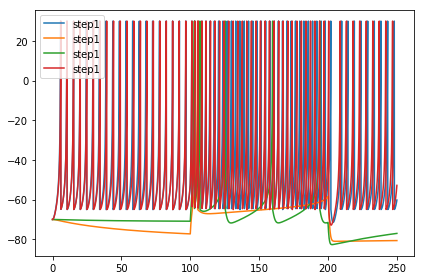

In [14]:
def plot_responses(responses, channels):
    for channel in channels:
        plt.plot(responses['step1.v'][channel]['time'], responses['step1.v'][channel]['voltage'], label='step1')
    plt.legend()
    plt.tight_layout()

plot_responses(responses, [0, 3, 7, 8])

### Defining features and objectives

For every response we need to define a set of features we will use for the fitness calculation later. We have to combine features together into objectives that will be used by the optimalisation algorithm. In this case we will create one objective per feature:

In [15]:
efel_feature_means = {'step1': feature_values}
print(efel_feature_means)

{'step1': {'time_to_second_spike': 6.0999999999982464, 'time_to_first_spike': 2.5999999999984453, 'time_to_last_spike': 99.499999999992951, 'Spikecount': 6}}


In [16]:
objectives = []

for protocol in sweep_protocols:
    stim_start = protocol.stimuli[0].step_delay
    stim_end = stim_start + protocol.stimuli[0].step_duration
    for efel_feature_name, mean in efel_feature_means[protocol.name].items():
        feature_name = '%s.%s' % (protocol.name, efel_feature_name)
        feature = ephys.efeatures.eFELFeature(
                    feature_name,
                    efel_feature_name=efel_feature_name,
                    recording_names={'': '%s.v' % protocol.name},
                    stim_start=stim_start,
                    stim_end=stim_end,
                    exp_mean=mean,
                    exp_std=0.2 * mean)
        objective = ephys.objectives.SingletonObjective(feature_name, feature)
        objectives.append(objective)

We can now evaluate the features for the responses we obtained:

In [17]:
for objective in objectives:
    feature = objective.features[0]
    print(feature.name)
    print([feature.calculate_feature({'step1.v': responses['step1.v'][channel]})
           for channel in range(POP_SIZE)])

step1.time_to_second_spike
[-89.500000000000028, -86.000000000000028, -83.700000000000045, None, -91.000000000000014, -88.000000000000028, -69.199999999999832, 6.9999999999981952, -89.500000000000028, -65.199999999999775, -89.100000000000023, 6.299999999998235, -56.299999999999649, 9.8999999999980304, 7.7999999999981497, 6.6999999999982123, -89.000000000000028, -69.199999999999832, -67.299999999999812, -75.89999999999992, -90.100000000000023, -57.899999999999672, -87.700000000000031, 10.399999999998002, -89.000000000000028, -77.899999999999949, -72.399999999999878, 11.999999999997911, -78.399999999999963, -62.499999999999737, -45.299999999999493, -91.700000000000017, -75.099999999999909, -59.399999999999693, -87.200000000000031, None, -87.500000000000028, -75.39999999999992, 7.3999999999981725, -79.399999999999977, 20.899999999997405, -81.400000000000006, -16.400000000000475, -35.999999999999361, -10.900000000000787, -84.700000000000045, -41.799999999999443, -82.200000000000017, -88.00

### Creating the population evaluator

We will need an object that can use these objective definitions to calculate the scores from a protocol response. This is called a ScoreCalculator.

In [18]:
score_calc = ephys.objectivescalculators.ObjectivesCalculator(objectives) 

Combining everything together we have a PopulationEvaluator. The PopulationEvaluator constructor has a field 'parameter_names' which contains the (ordered) list of names of the parameters that are used as input (and will be fitted later on).

In [19]:
pop_evaluator = epyn.evaluators.PopulationEvaluator(
        cell_model=simple_population,
        param_names=['a', 'b'],
        fitness_protocols={single_step_protocol.name: single_step_protocol},
        fitness_calculator=score_calc,
        isolate_protocols=False,
        sim=simulator)

### Evaluating the cells

The population of cells can now be evaluated for a certain set of parameter values.

In [20]:
_print(pop_evaluator.evaluate_with_dicts(default_params))

[{'step1.Spikecount': 47.49999999999999,
  'step1.time_to_first_spike': 185.96153846164668,
  'step1.time_to_last_spike': 2.442211055276416,
  'step1.time_to_second_spike': 78.36065573772602},
 {'step1.Spikecount': 33.33333333333333,
  'step1.time_to_first_spike': 183.0769230770296,
  'step1.time_to_last_spike': 2.3819095477387267,
  'step1.time_to_second_spike': 75.4918032787088},
 {'step1.Spikecount': 26.666666666666664,
  'step1.time_to_first_spike': 180.96153846164373,
  'step1.time_to_last_spike': 2.4723618090452604,
  'step1.time_to_second_spike': 73.60655737706894},
 {'step1.Spikecount': 4.166666666666666,
  'step1.time_to_first_spike': 5.384615384618298,
  'step1.time_to_last_spike': 4.728643216080469,
  'step1.time_to_second_spike': 250.0},
 {'step1.Spikecount': 56.66666666666666,
  'step1.time_to_first_spike': 187.30769230780132,
  'step1.time_to_last_spike': 2.4020100502512896,
  'step1.time_to_second_spike': 79.59016393444767},
 {'step1.Spikecount': 39.166666666666664,
  's

## Setting up and running an optimisation

Now that we have a cell template and an evaluator for this cell, we can set up an optimisation.

In [21]:
optimisation = bpop.optimisations.DEAPOptimisation(
                    evaluator=pop_evaluator,
                    offspring_size=POP_SIZE,
                    hof=deap.tools.HallOfFame(POP_SIZE),
                    map_function=lambda evaluate, population: evaluate(population))

And this optimisation can be run for a certain number of generations

In [22]:
final_pop, hall_of_fame, logs, hist = optimisation.run(max_ngen=10)

The optimisation has returned us 4 objects: final population, hall of fame, statistical logs and history. 

The final population contains a list of tuples, with each tuple representing the two parameters of the model

In [23]:
print('Final population: ', final_pop)

Final population:  [[0.020004631722597532, 0.20306667008824203], [0.019811770686960058, 0.20462761491467002], [0.019449315025769243, 0.20470444073884525], [0.019449315025769243, 0.20470444073884525], [0.020004631722597532, 0.20409861198152376], [0.031631351301387445, 0.1883987917566379], [0.031631351301387445, 0.1883987917566379], [0.031899841213926916, 0.21998426419901213], [0.031899841213926916, 0.21998426419901213], [0.031899841213926916, 0.21998426419901213], [0.007846922224472863, 0.2637947781011488], [0.007846922224472863, 0.2637947781011488], [0.007846922224472863, 0.2637947781011488], [0.007846922224472863, 0.2637947781011488], [0.031899841213926916, 0.18717086421180543], [0.031899841213926916, 0.18717086421180543], [0.031899841213926916, 0.18717086421180543], [0.031899841213926916, 0.18717086421180543], [0.031899841213926916, 0.18717086421180543], [0.020004631722597532, 0.20470444073884525], [0.020004631722597532, 0.20470444073884525], [0.020004631722597532, 0.2047044407388452

The best individual found during the optimisation is the first individual of the hall of fame

In [24]:
best_ind = hall_of_fame[0:POP_SIZE]
print('Best five individuals: ', best_ind[:5])
print('Fitness values: ', [ind.fitness.values for ind in best_ind[:5]])

Best five individuals:  [[0.019009429835374226, 0.21953585794686914], [0.019988989791429303, 0.2218745673701669], [0.020070069656334545, 0.2215093469729816], [0.020004631722597532, 0.20306667008824203], [0.019811770686960058, 0.20462761491467002]]
Fitness values:  [(0.081967213114773, 0.0, 0.0, 0.3366834170854318), (0.081967213114773, 0.0, 0.0, 0.5577889447236258), (0.081967213114773, 0.0, 0.0, 0.5678391959799074), (0.327868852459092, 0.38461538461559275, 0.0, 0.01507537688442232), (0.327868852459092, 0.38461538461559275, 0.0, 0.03015075376884464)]


In [25]:
len(hall_of_fame)

100

We can evaluate the best individuals and make use of a convenience function of the cell evaluator to return us a dict of the parameters

In [26]:
best_ind_dict = pop_evaluator.param_dict(best_ind)
print(best_ind_dict)

{'a': array([ 0.01900943,  0.01998899,  0.02007007,  0.02000463,  0.01981177,
        0.01944932,  0.02000463,  0.02000463,  0.02009106,  0.01971524,
        0.02175361,  0.01055908,  0.02096881,  0.02007007,  0.02272502,
        0.02575418,  0.01151713,  0.02654263,  0.02314702,  0.01268091,
        0.00986654,  0.00986654,  0.0120894 ,  0.01901955,  0.01301339,
        0.0265953 ,  0.03189984,  0.02685972,  0.03214296,  0.02130683,
        0.03245135,  0.03189984,  0.03212206,  0.03189984,  0.03189984,
        0.03189984,  0.03452583,  0.03222543,  0.02904079,  0.03452583,
        0.03189984,  0.01744684,  0.03448111,  0.03186445,  0.03189984,
        0.03189984,  0.02592224,  0.00513683,  0.03189984,  0.0347756 ,
        0.031221  ,  0.03189984,  0.03190559,  0.03190567,  0.03190539,
        0.03189984,  0.03189984,  0.0143167 ,  0.01683858,  0.03247905,
        0.03247905,  0.03289504,  0.03189984,  0.01644471,  0.0326648 ,
        0.03189984,  0.03189984,  0.03452583,  0.0059688 ,

As you can see the evaluation returns the same values as the fitness values provided by the optimisation output. 
We can have a look at the responses now.

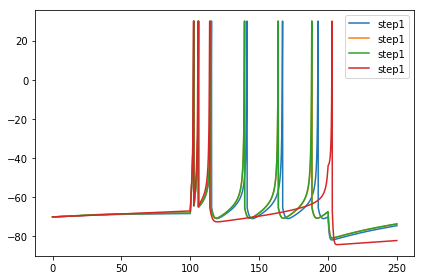

In [27]:
plot_responses(single_step_protocol.run(cell_model=simple_population,
                                        param_values=best_ind_dict,
                                        sim=simulator,
                                        isolate=False),
              [0, 1, 2, POP_SIZE-1])

We can see that the first three best individuals in the hall of fame are very close to the target, and even the 100th best individual is closer to the target than the members of the original population.

Let's have a look at the optimisation statistics.
We can plot the minimal score (sum of all objective scores) found in every optimisation. 
The optimisation algorithm uses negative fitness scores, so we actually have to look at the maximum values log.

(0.37678556718018436, 1.9994877709270997)

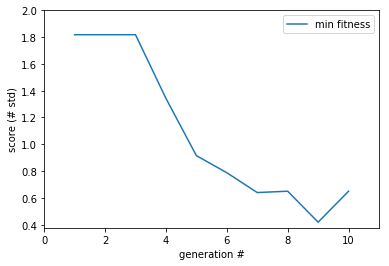

In [28]:
import numpy
gen_numbers = logs.select('gen')
min_fitness = logs.select('min')
max_fitness = logs.select('max')
plt.plot(gen_numbers, min_fitness, label='min fitness')
plt.xlabel('generation #')
plt.ylabel('score (# std)')
plt.legend()
plt.xlim(min(gen_numbers) - 1, max(gen_numbers) + 1) 
plt.ylim(0.9*min(min_fitness), 1.1 * max(min_fitness)) 